<a href="https://colab.research.google.com/github/manualrg/dslab-nlp-dl/blob/master/06_dlnlp_rnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neuronales Recurrentes

In [ ]:
import typing

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
print(f"{np.__version__=}")
print(f"{pd.__version__=}")

np.__version__='2.0.2'
pd.__version__='2.2.2'


# Introducción: Neurona Artificial

In [ ]:
# Dataset (X: inputs, y: outputs)

X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])

y = np.array([0, 0, 0, 1]) # clasificacion binaria

# Inicialización de parametros: w ~random, b =0
weights = np.random.rand(X.shape[1])
bias = 0

# Funcion de activacion (Heaviside step function)
def activate(summation):
  return 1 if summation >= 0 else 0

# Entrenamiento
epochs = 10  # pases al dataset
learning_rate = 0.1

print("\nTraining the Perceptron...")

for epoch in range(epochs):
  for i in range(X.shape[0]):  # batches de 1 fila

    ##  Forward:
    # Calculate the weighted sum of inputs
    weighted_sum = np.dot(X[i], weights) + bias

    # Get the predicted output (logits)
    prediction = activate(weighted_sum)

    ## Backwards:
    # CAlcular el error para el estado actual de los parameros de la red
    loss = y[i] - prediction
    # Actualizacion mediante `backprop`
    weights += learning_rate * loss * X[i]
    bias += learning_rate * loss

print("Training complete.")
print(f"Final weights: {weights}")
print(f"Final bias: {bias}")

# Testing the perceptron (Forward solo)
print("\nTesting the Perceptron:")
for i in range(X.shape[0]):
  weighted_sum = np.dot(X[i], weights) + bias
  prediction = activate(weighted_sum)
  print(f"Input: {X[i]}, Predicted Output: {prediction}, Expected Output: {y[i]}")



Training the Perceptron...
Training complete.
Final weights: [0.37127035 0.17404465]
Final bias: -0.5

Testing the Perceptron:
Input: [0 0], Predicted Output: 0, Expected Output: 0
Input: [0 1], Predicted Output: 0, Expected Output: 0
Input: [1 0], Predicted Output: 0, Expected Output: 0
Input: [1 1], Predicted Output: 1, Expected Output: 1


# Funciones de Activacion

Cada capa se compone de la operción que involucra a los pesos `W` y el sesgo `b`  o bias y luego se le aplica una funcion de activación para introducir no linealidad

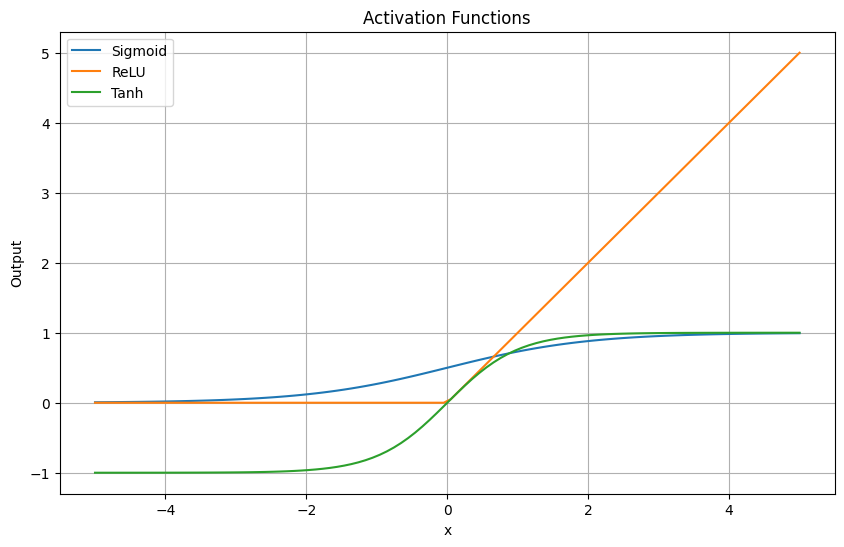

In [ ]:

def sigmoid(x: typing.Union[np.ndarray, float]) -> typing.Union[np.ndarray, float]:
  """
  Implements the sigmoid function.

  Args:
    x: The input, can be a float or a numpy array.

  Returns:
    The output of the sigmoid function applied to x.
  """
  return 1 / (1 + np.exp(-x))


def relu(x: typing.Union[np.ndarray, float]) -> typing.Union[np.ndarray, float]:
  """
  Implements the ReLU (Rectified Linear Unit) function.

  Args:
    x: The input, can be a float or a numpy array.

  Returns:
    The output of the ReLU function applied to x.
  """
  return np.maximum(0, x)


def tanh(x: typing.Union[np.ndarray, float]) -> typing.Union[np.ndarray, float]:
  """
  Implements the tanh (hyperbolic tangent) function.

  Args:
    x: The input, can be a float or a numpy array.

  Returns:
    The output of the tanh function applied to x.
  """
  return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

# Example usage:
x_values = np.linspace(-5, 5, 100)

sigmoid_output = sigmoid(x_values)
relu_output = relu(x_values)
tanh_output = tanh(x_values)

plt.figure(figsize=(10, 6))

plt.plot(x_values, sigmoid_output, label='Sigmoid')
plt.plot(x_values, relu_output, label='ReLU')
plt.plot(x_values, tanh_output, label='Tanh')

plt.title('Activation Functions')
plt.xlabel('x')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()


La función `softmax` es imprescindible en clasificación multiclase, pues conviernte los logits en bruto en probabilidades reales

In [ ]:
def softmax(x: np.ndarray) -> np.ndarray:
  """
  Implements the softmax function.

  Args:
    x: The input, a numpy array (typically representing raw scores or logits).

  Returns:
    The output of the softmax function applied to x, a numpy array of probabilities.
  """
  # Subtract the maximum value for numerical stability
  e_x = np.exp(x - np.max(x))
  return e_x / e_x.sum(axis=0)


# logits: raw scores from the output layer (3 class target)
logits = np.array([1.0, 2.0, 0.5])

probabilities = softmax(logits)

print(f"Raw scores (logits): {logits}")
print(f"Probabilities after softmax: {probabilities}")
print(f"Sum of probabilities: {probabilities.sum()}")

Raw scores (logits): [1.  2.  0.5]
Probabilities after softmax: [0.2312239  0.62853172 0.14024438]
Sum of probabilities: 1.0


**Intuición**

Los pesos (parámetros) de la red almacenan los parámetros generales, mientras que las activciones se obtienen al pasar datos por la misma, por lo que es la respuesta de la red a la presencia de ese dato concreto

Para interpretar por qué una red funciona como lo hace, hay que estudiar las activaciones

# RNN Vanilla

## Encoding

La entrada a una RNN siempre es la representación vectorial del string, normalmente es un vector denso, pero en este caso, por simplicidad, asignemos un vector `sparse`

In [ ]:
char_to_ix = {'h':0, 'e':1, 'l':2, 'o':3, '_':4}
ix_to_char = {i:ch for ch, i in char_to_ix.items()}
vocab_size = len(char_to_ix)

def one_hot(c):
    v = np.zeros((vocab_size, 1))
    v[char_to_ix[c]] = 1
    return v

one_hot("h")

array([[1.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [ ]:
one_hot("e")

array([[0.],
       [1.],
       [0.],
       [0.],
       [0.]])

In [ ]:
try:
  one_hot("a")
except KeyError as err:
  print("ERROR. El caracter no se encuentra en el vocabulario `char_to_ix`:", err)

ERROR. El caracter no se encuentra en el vocabulario `char_to_ix`: 'a'


## Inicialización de pesos

Wab: matriz de pesos para pasar de `a` a `b`  con el producto escalar (dot product): b = Wab · a, por lo tanto, siempre tienen dimensiones:  

b[Nbx1] = Wab [NbxNa] · a [Nax1]


* Wxh =  input to hidden
* Whh =  hidden to hidden
* Why =  hidden to output

Adicionalmente, se tienen los vectore de `bias`
* bh, by

In [ ]:
np.random.seed(42)

# Dimensiones
vocab_size = len(char_to_ix)
hidden_size = 4

Wxh = np.random.randn(hidden_size, vocab_size)
Whh = np.random.randn(hidden_size, hidden_size)  # hidden to hidden
Why = np.random.randn(vocab_size, hidden_size)  # hidden to output
bh = np.zeros((hidden_size, 1))
by = np.zeros((vocab_size, 1))


## Forward paso a paso

In [ ]:
input_sequence = "hell"  # cada caracter se vectorizará para pasar secuencialmente por la red

Ejemplo de las dimensiones y del producto escalar

In [ ]:
x_in = one_hot("h")

x_in

array([[1.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [ ]:
Wxh.shape, x_in.shape

((4, 5), (5, 1))

In [ ]:
res = np.dot(Wxh, x_in)
res.shape

(4, 1)

In [ ]:
# Forward pass
hs = {}  # activaciones
hs[-1] = np.zeros((hidden_size, 1))  # estado inicial

xs, ys, ps = {}, {}, {}

for t, char in enumerate(input_sequence):
    xs[t] = one_hot(char)
    hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh)
    ys[t] = np.dot(Why, hs[t]) + by
    ps[t] = softmax(ys[t])


## Visualización

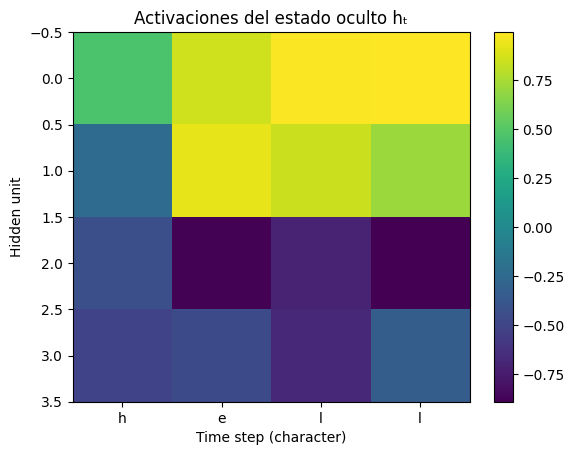

In [ ]:
activ_matrix = np.hstack([hs[t] for t in range(len(input_sequence))])

plt.imshow(activ_matrix, cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel("Time step (character)")
plt.ylabel("Hidden unit")
plt.xticks(range(len(input_sequence)), list(input_sequence))
plt.title("Activaciones del estado oculto hₜ")
plt.show()


🔁 Las activaciones de hₜ retienen memoria: el estado oculto lleva información del pasado.

🔄 Se puede visualizar cómo ciertos caracteres afectan más a determinadas neuronas ocultas.

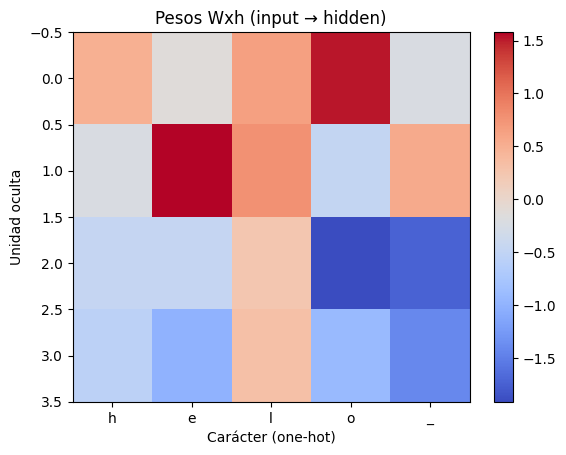

In [ ]:
plt.imshow(Wxh, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xlabel("Carácter (one-hot)")
plt.ylabel("Unidad oculta")
plt.title("Pesos Wxh (input → hidden)")
plt.xticks(range(vocab_size), list(char_to_ix.keys()))
plt.show()


🔍 Los pesos Wxh (aunque aleatorios en el ejemplo) revelan cómo el modelo "atiende" a diferentes letras del vocabulario (que no de la secuencia)

# EOF